In [1]:
import time
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import jumpy
import jax
import jax.numpy as jnp  # todo: replace with from brax import jumpy.numpy as jp.ndarray?
import jax.random as rnd

import rex.utils as utils
import rex.open_colors as oc
from rex.proto import log_pb2
from rex.node import Node
from rex.agent import Agent
from rex.constants import LATEST, BUFFER, SILENT, DEBUG, INFO, WARN, SYNC, ASYNC, REAL_TIME, FAST_AS_POSSIBLE, FREQUENCY, PHASE, SIMULATED, WALL_CLOCK
from rex.distributions import Gaussian, GMM
from rex.base import GraphState, StepState
from scripts.dummy import DummyNode, DummyAgent

utils.set_log_level(WARN)

In [2]:
# Create nodes
world = DummyNode("world",           rate=20, delay_sim=Gaussian(0.000), scheduling=PHASE)
sensor = DummyNode("sensor",         rate=20, delay_sim=Gaussian(0.007), scheduling=PHASE)
observer = DummyNode("observer",     rate=30, delay_sim=Gaussian(0.016), scheduling=PHASE)
agent = DummyAgent("agent",          rate=45, delay_sim=Gaussian(0.005, 0.001), scheduling=PHASE, advance=True)
actuator = DummyNode("actuator",     rate=45, delay_sim=Gaussian(1/45), scheduling=PHASE, advance=False, stateful=True)
nodes = [world, sensor, observer, agent, actuator]

# Connect
sensor.connect(world,        blocking=False, delay_sim=Gaussian(0.004), skip=False, jitter=LATEST)
observer.connect(sensor,     blocking=False, delay_sim=Gaussian(0.003), skip=False, jitter=BUFFER)
observer.connect(agent,      blocking=False, delay_sim=Gaussian(0.003), skip=True, jitter=LATEST)
agent.connect(observer,      blocking=True, delay_sim=Gaussian(0.003), skip=False, jitter=BUFFER)
actuator.connect(agent,      blocking=False, delay_sim=Gaussian(0.003, 0.001), skip=False, jitter=BUFFER)
world.connect(actuator,      blocking=False, delay_sim=Gaussian(0.004), skip=True, jitter=BUFFER)

[10524][MainThread               ][actuator            ][WARNING             ] The sampling time (1/rate=0.022222 s) is smaller than the output phase (self.output.phase=0.022222 s). This may lead to large (accumulating) delays.


In [3]:
# Warmup nodes (pre-compile jitted functions)
[n.warmup() for n in nodes]

# Get PRNG
seed = rnd.PRNGKey(0)
rngs = rnd.split(seed, num=len(nodes))

# Show effect real-time factor
real_time_factor, clock = FAST_AS_POSSIBLE, SIMULATED
# real_time_factor, clock = 20, WALL_CLOCK

# Get graph state
def reset_node(node, rng):
    rng_params, rng_state, rng_inputs, rng_step, rng_reset = jumpy.random.split(rng, num=5)
    params = node.default_params(rng_params)
    state = node.default_state(rng_state)
    inputs = node.default_inputs(rng_inputs)
    node.reset(rng_reset)
    return StepState(rng=rng_step, params=params, state=state, inputs=inputs)

node_ss = {n.name: reset_node(n, rng) for n, rng in zip(nodes, rngs)}
graph_state = GraphState(step=0, nodes=node_ss)

# Reset nodes (Allows setting the run mode)
[n._reset(graph_state, real_time_factor=real_time_factor, clock=clock) for rng, n in zip(rngs, nodes)]

# An additional reset is required when running async (futures, etc..)
agent._agent_reset()

# Check that all nodes have the same episode counter
assert len({n.eps for n in nodes}) == 1, "All nodes must have the same episode counter"

# Start nodes (provide same starting timestamp to every node)
num_steps = 500
start = time.time()
[n._start(start=start) for n in nodes]

# Simulate
tstart = time.time()
step_state = agent.observation.popleft().result()  # Retrieve first obs
for _ in range(num_steps):
    action = agent.default_output(seed)  # NOTE! Re-using the seed here.
    agent.action[-1].set_result((step_state, action))  # The set result must be the action of the agent.
    step_state = agent.observation.popleft().result()  # Retrieve observation
tend = time.time()

# Initiate reset
agent.action[-1].cancel()  # Cancel to stop the actions being sent by the agent node.

# Stop all ndoes
fs = [n._stop() for n in nodes]

# Wait for nodes to have stopped
[f.result() for f in fs]

print(f"agent_steps={num_steps} | node_steps={[n._i for n in nodes]} | t={(tend - tstart): 2.4f} sec | fps={num_steps / (tend - tstart): 2.4f}")

# Gather the records
record = log_pb2.EpisodeRecord()
[record.node.append(node.record()) for node in nodes]
d = {n.info.name: n for n in record.node}

agent_steps=500 | node_steps=[0, 0, 0, 0, 0] | t= 1.0290 sec | fps= 485.9147


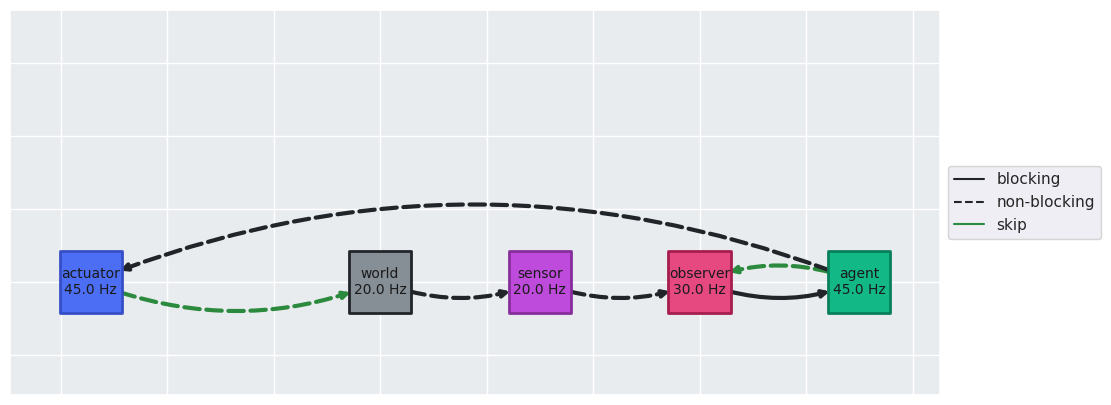

In [4]:
from rex.plot import plot_graph

# Create new plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.set(facecolor=oc.ccolor("gray"))

# Draw graph
pos = {"world": (0, 0), "sensor": (1.5, 0), "observer": (3, 0), "agent": (4.5, 0)}
cscheme = {"sensor": "grape", "observer": "pink", "agent": "teal", "actuator": "indigo"}
plot_graph(ax, record, cscheme=cscheme, pos=pos)

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False,
          bbox_to_anchor=(1.0, 0.50))

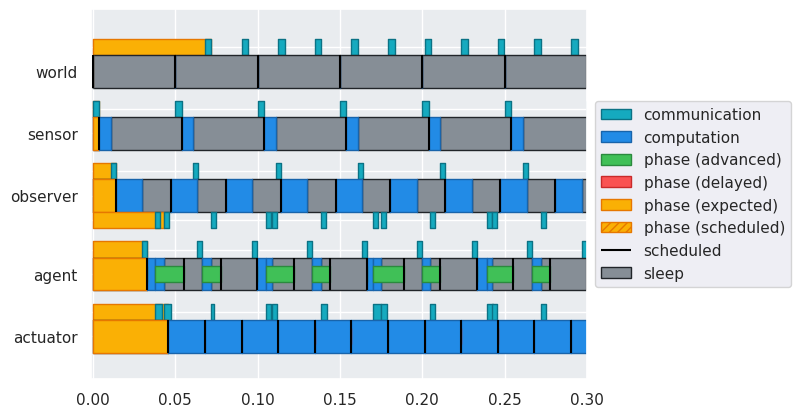

In [5]:
from rex.plot import plot_input_thread, plot_event_thread

# Create new plots
fig, ax = plt.subplots()
xlim = [-0.001, 0.3]
ax.set(ylim=[-18, 95], xlim=xlim, yticks=[], facecolor=oc.ccolor("gray"))
ystart, dy, margin = 90, -10, 4

# Plot all thread traces
ystart = plot_input_thread(ax, d["world"].inputs[0], ystart=ystart-margin, dy=dy/2, name="")
ystart = plot_event_thread(ax, d["world"], ystart=ystart, dy=dy)

ystart = plot_input_thread(ax, d["sensor"].inputs[0], ystart=ystart-margin, dy=dy/2, name="")
ystart = plot_event_thread(ax, d["sensor"], ystart=ystart, dy=dy)

ystart = plot_input_thread(ax, d["observer"].inputs[0], ystart=ystart-margin, dy=dy/2, name="")
ystart = plot_event_thread(ax, d["observer"], ystart=ystart, dy=dy)
ystart = plot_input_thread(ax, d["observer"].inputs[1], ystart=ystart, dy=dy/2, name="")

ystart = plot_input_thread(ax, d["agent"].inputs[0], ystart=ystart-margin, dy=dy/2, name="")
ystart = plot_event_thread(ax, d["agent"], ystart=ystart, dy=dy)

ystart = plot_input_thread(ax, d["actuator"].inputs[0], ystart=ystart-margin, dy=dy/2, name="")
ystart = plot_event_thread(ax, d["actuator"], ystart=ystart, dy=dy)

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False, 
          bbox_to_anchor=(1.0, 0.50))

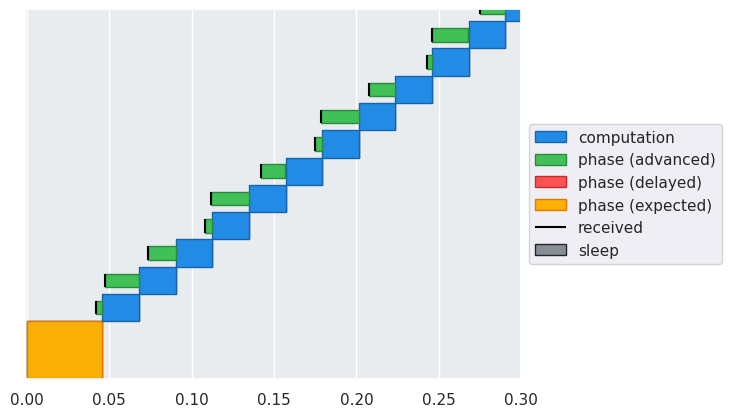

In [6]:
from rex.plot import plot_grouped

# Create new plot
fig, ax = plt.subplots()
ax.set(ylim=xlim, xlim=xlim, yticks=[], facecolor=oc.ccolor("gray"))

# Function arguments
# plot_grouped(ax, d["observer"], "agent")
plot_grouped(ax, d["actuator"])

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False, 
          bbox_to_anchor=(1.0, 0.50))

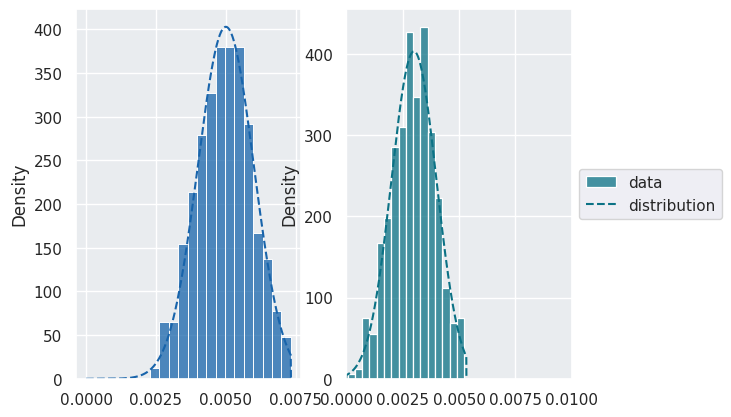

In [11]:
from rex.plot import plot_delay

# Create new plots
fig, axes = plt.subplots(ncols=2)
[ax.set(facecolor=oc.ccolor("gray")) for ax in axes.flatten().tolist()]

# Plot delays
plot_delay(axes[0], d["agent"], clock=SIMULATED)
plot_delay(axes[1], d["actuator"].inputs[0], clock=SIMULATED)

# axes[0].set(xlim=[0, 0.0025])
axes[1].set(xlim=[0, 0.01])

# Plot legend
handles, labels = axes[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
axes[1].legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False, 
          bbox_to_anchor=(1.0, 0.50))

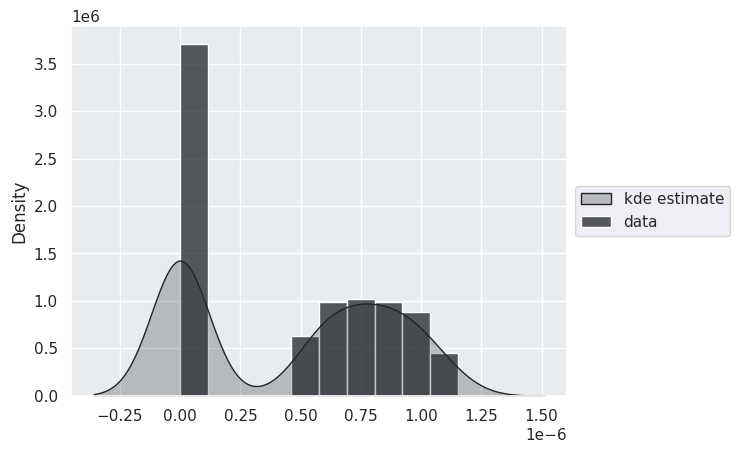

In [13]:
from rex.plot import plot_step_timing

# Create new plots
fig, ax = plt.subplots()
ax.set(facecolor=oc.ccolor("gray"))

# Plot step timing variation
plot_step_timing(ax, d["actuator"], ["delayed", "advanced", "ontime"])
# plot_step_timing(ax, d["actuator"], ["delayed", "ontime"])
# plot_step_timing(ax, d["agent"], ["advanced", "ontime"])
# plot_step_timing(ax, d["agent"], ["advanced"])
# plot_step_timing(ax, d["actuator"], "delayed", name="delayed")
# plot_step_timing(ax, d["actuator"], "advanced", name="advanced")
# plot_step_timing(ax, d["actuator"], "ontime", name="on time")

# Plot legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=1, loc='center left', fancybox=True, shadow=False, bbox_to_anchor=(1.0, 0.50))

In [9]:
# Trace steps
from rex.tracer import trace

# Set actuator to be stateless
d["actuator"].info.stateful = False
# d['actuator'].inputs[0].info.window = 2

# Trace record
traceback = trace(record, "agent", -1, static=True)

Trace | name='agent' | tick=500 | deps (seq): 3052/4053 | step (seq): 1502/1782 | steps (batch): 2289/1782 | steps (vec): 6501/1782 (max_consecutive=3)


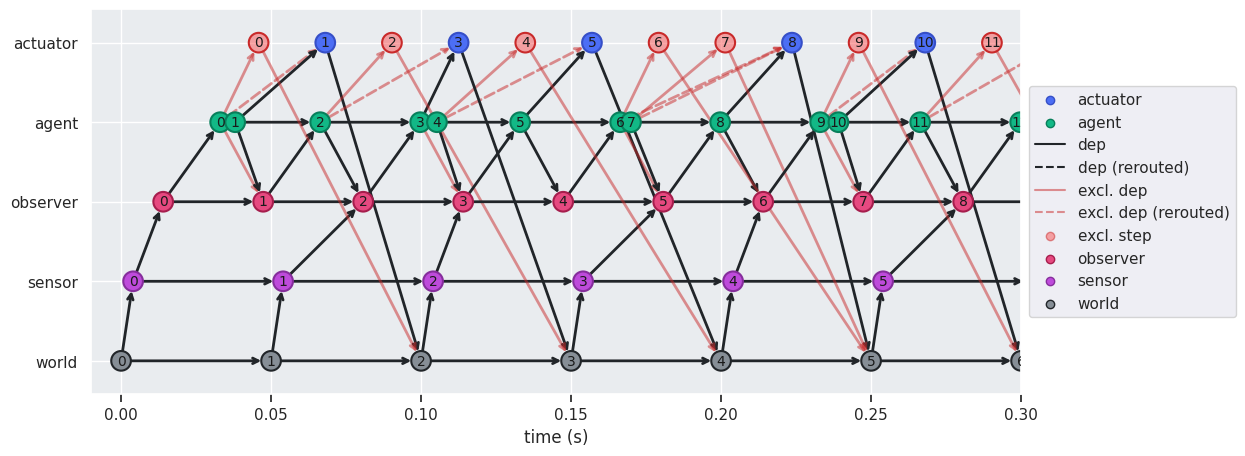

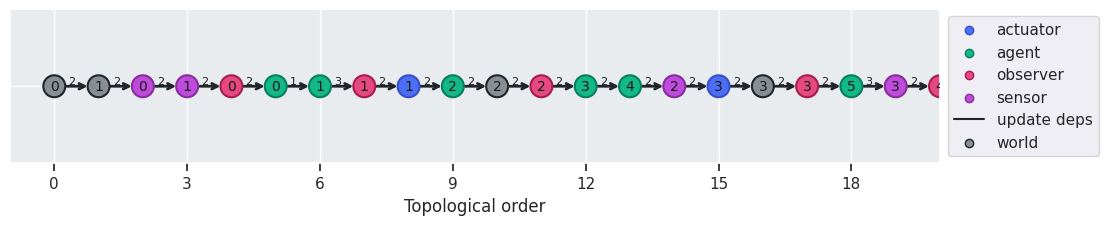

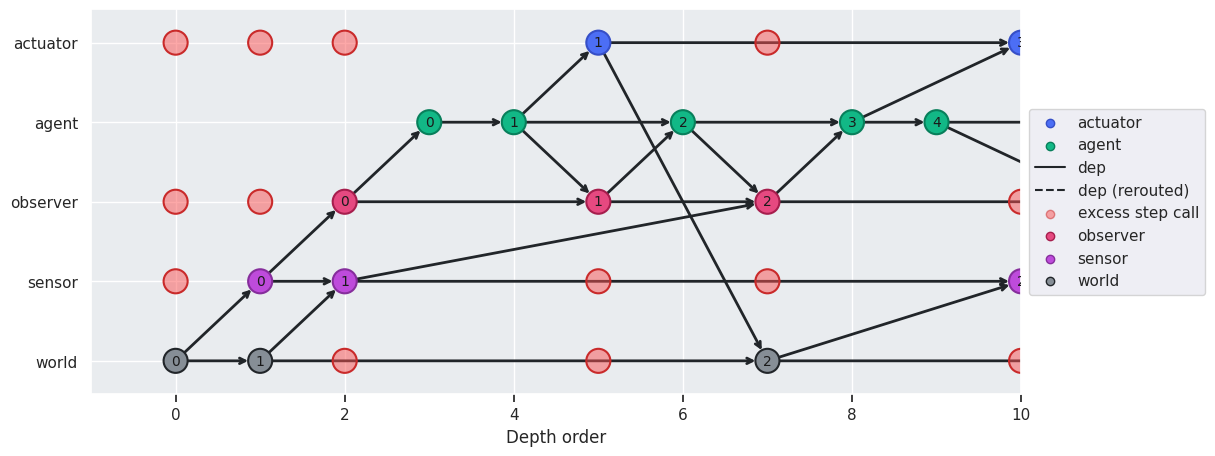

In [10]:
from rex.plot import plot_computation_graph, plot_topological_order, plot_depth_order
from matplotlib.ticker import MaxNLocator

# Create new plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.set(facecolor=oc.ccolor("gray"), xlabel="time (s)", yticks=[], xlim=[-0.01, 0.3])

# Plot graph
order = ["world",  "sensor", "observer", "agent", "actuator"]
cscheme = {"sensor": "grape", "observer": "pink", "agent": "teal", "actuator": "indigo"}
plot_computation_graph(ax, traceback, order=order, cscheme=cscheme, xmax=0.6, node_size=200, draw_excluded=True, draw_stateless=False, draw_edgelabels=False, draw_nodelabels=True)

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False,
          bbox_to_anchor=(1.0, 0.50))

# Create new plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 2)
ax.set(facecolor=oc.ccolor("gray"), xlabel="Topological order", yticks=[], xlim=[-1, 20])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plot_topological_order(ax, traceback, xmax=0.6, cscheme=cscheme)

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False,
          bbox_to_anchor=(1.0, 0.50))

# Create new plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
ax.set(facecolor=oc.ccolor("gray"), xlabel="Depth order", yticks=[], xlim=[-1, 10])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plot_depth_order(ax, traceback, xmax=0.6, cscheme=cscheme, node_labeltype="tick", draw_excess=True)

# Plot legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
by_label = dict(sorted(by_label.items()))
ax.legend(by_label.values(), by_label.keys(), ncol=1, loc='center left', fancybox=True, shadow=False,
          bbox_to_anchor=(1.0, 0.50))
